In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
command_file_name = "../data/command/japan_command.json"
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
celeri.create_output_folder(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

Using precomputed elastic operators


# Calculate non-elastic operators

In [5]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Debugging H-matrix problems (much of this can be deleted)

In [6]:
# from celeri.hmatrix import build_hmatrix_from_mesh_tdes
# from celeri.hmatrix import build_hmatrix_from_mesh_tdes_new # Only difference is that you can pass TDE matrix directly

# H = []

# for i in range(len(meshes)):
#     H.append(build_hmatrix_from_mesh_tdes_new(
#         meshes[i], 
#         station,
#         operators.tde_to_velocities[i],
#         1e-6,
#         # TBT: min_separation is a ratio of the sizes of the two tree nodes. The
#         # exact criteria for two nodes being far enough apart that we are allowed to
#         # use an approximate matrix block instead of an exact matrix block is:
#         # dist > min_separation * (obs_node.radius + src_node.radius)
#         min_separation=1.25,
#         min_pts_per_box=20,
#     ))

# for i in range(len(meshes)):
#     print(H[i].report_compression_ratio())

# M = operators.tde_to_velocities[0]
# M = np.delete(M, np.arange(2, M.shape[0], 3), axis=0)
# M = np.delete(M, np.arange(2, M.shape[1], 3), axis=1)
# M4d = M.reshape((-1, 2, M.shape[1] // 2, 2))

# x = np.random.rand(M.shape[1])
# self = H[0]
# n_obs = self.shape[0] // 2
# y_tree = np.zeros((n_obs, 2))
# x_tree = x.reshape((-1, 2))[self.src_tree.ordered_idxs]

# for i, (obs_node, src_node) in enumerate(self.direct_pairs):
#     x_block = x_tree[src_node.idx_start : src_node.idx_end]
#     term = self.direct_blocks[i].dot(x_block.ravel()).reshape((-1, 2))
    
#     # Exact 
#     obs_idxs = self.obs_tree.ordered_idxs[obs_node.idx_start : obs_node.idx_end]
#     src_idxs = self.src_tree.ordered_idxs[src_node.idx_start : src_node.idx_end]
#     exact = np.tensordot(M4d[obs_idxs, :][:, :, src_idxs], x_block)
#     np.testing.assert_allclose(exact, term)

# for i, (obs_node, src_node) in enumerate(self.approx_pairs):
#     x_block = x_tree[src_node.idx_start : src_node.idx_end]
#     U, V = self.approx_blocks[i]
#     term = U.dot(V.dot(x_block.ravel())).reshape((-1, 2))

#     obs_idxs = self.obs_tree.ordered_idxs[obs_node.idx_start : obs_node.idx_end]
#     src_idxs = self.src_tree.ordered_idxs[src_node.idx_start : src_node.idx_end]
#     exact = np.tensordot(M4d[obs_idxs, :][:, :, src_idxs], x_block)
#     try:
#         np.testing.assert_allclose(exact, term, atol=1e-6)
#     except:
#         print('bad idx', i)
#         raise

# # bad index was 43
# # obs_node, src_node = self.approx_pairs[43]
# # obs_idxs = self.obs_tree.ordered_idxs[obs_node.idx_start : obs_node.idx_end]
# # src_idxs = self.src_tree.ordered_idxs[src_node.idx_start : src_node.idx_end]
# # h_block = M4d[obs_idxs, :][:, :, src_idxs]
# # h_block = h_block.reshape((h_block.shape[0] * 2, -1))
# # U, S, V = np.linalg.svd(h_block, full_matrices=False)
# # block_tol = self.tol * (h_block.size / M4d.size) * self.frob_est
# # frob_K = np.sqrt(np.cumsum(S[::-1] ** 2))[::-1]
# # appx_rank = np.argmax(frob_K < block_tol)
# # self.approx_blocks[43], S, block_tol, frob_K, appx_rank

# for i in range(len(meshes)):
#     M = operators.tde_to_velocities[i]
#     M = np.delete(M, np.arange(2, M.shape[0], 3), axis=0)
#     M = np.delete(M, np.arange(2, M.shape[1], 3), axis=1)

#     x = np.random.rand(M.shape[1])
#     y_true = M.dot(x)
#     y_h = H[i].dot(x)

#     log10err = np.log10(np.abs(y_true - y_h))
#     plt.hist(log10err, bins=np.linspace(-12,0,21))
#     plt.ylabel('N')
#     plt.xlabel('log 10 error')
#     plt.show()

#     plt.figure()
#     plt.scatter(station.lon, station.lat, c=log10err[0::2])
#     plt.colorbar()
#     plt.show()

# Plot input data

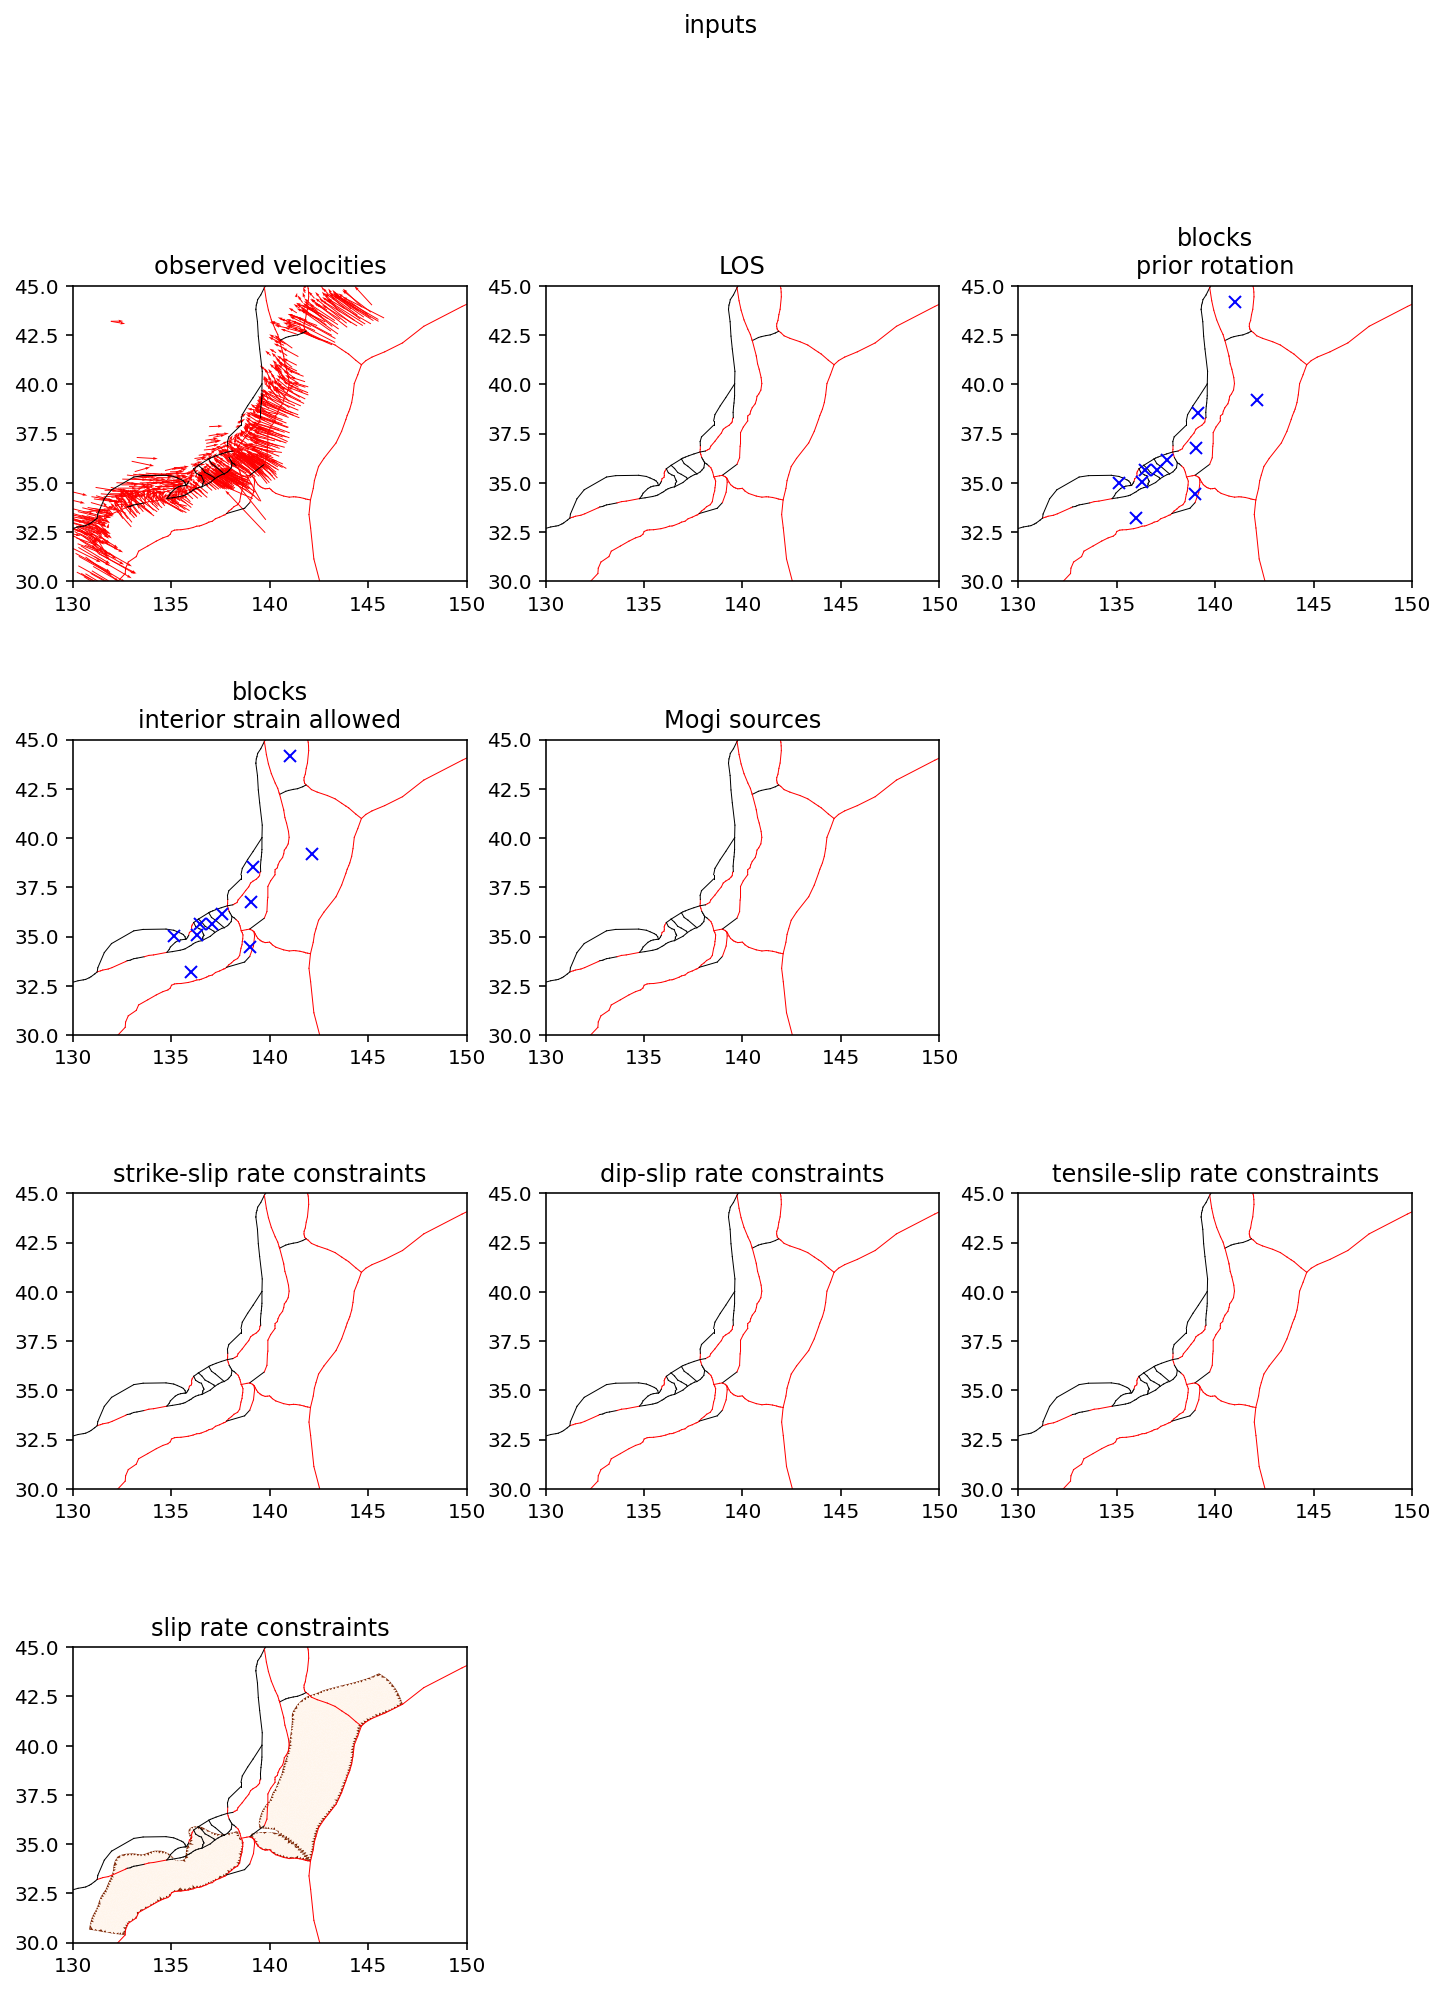

In [7]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [8]:
index, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
# celeri.write_output(command, estimation, station, segment, block)

# Plot model summary

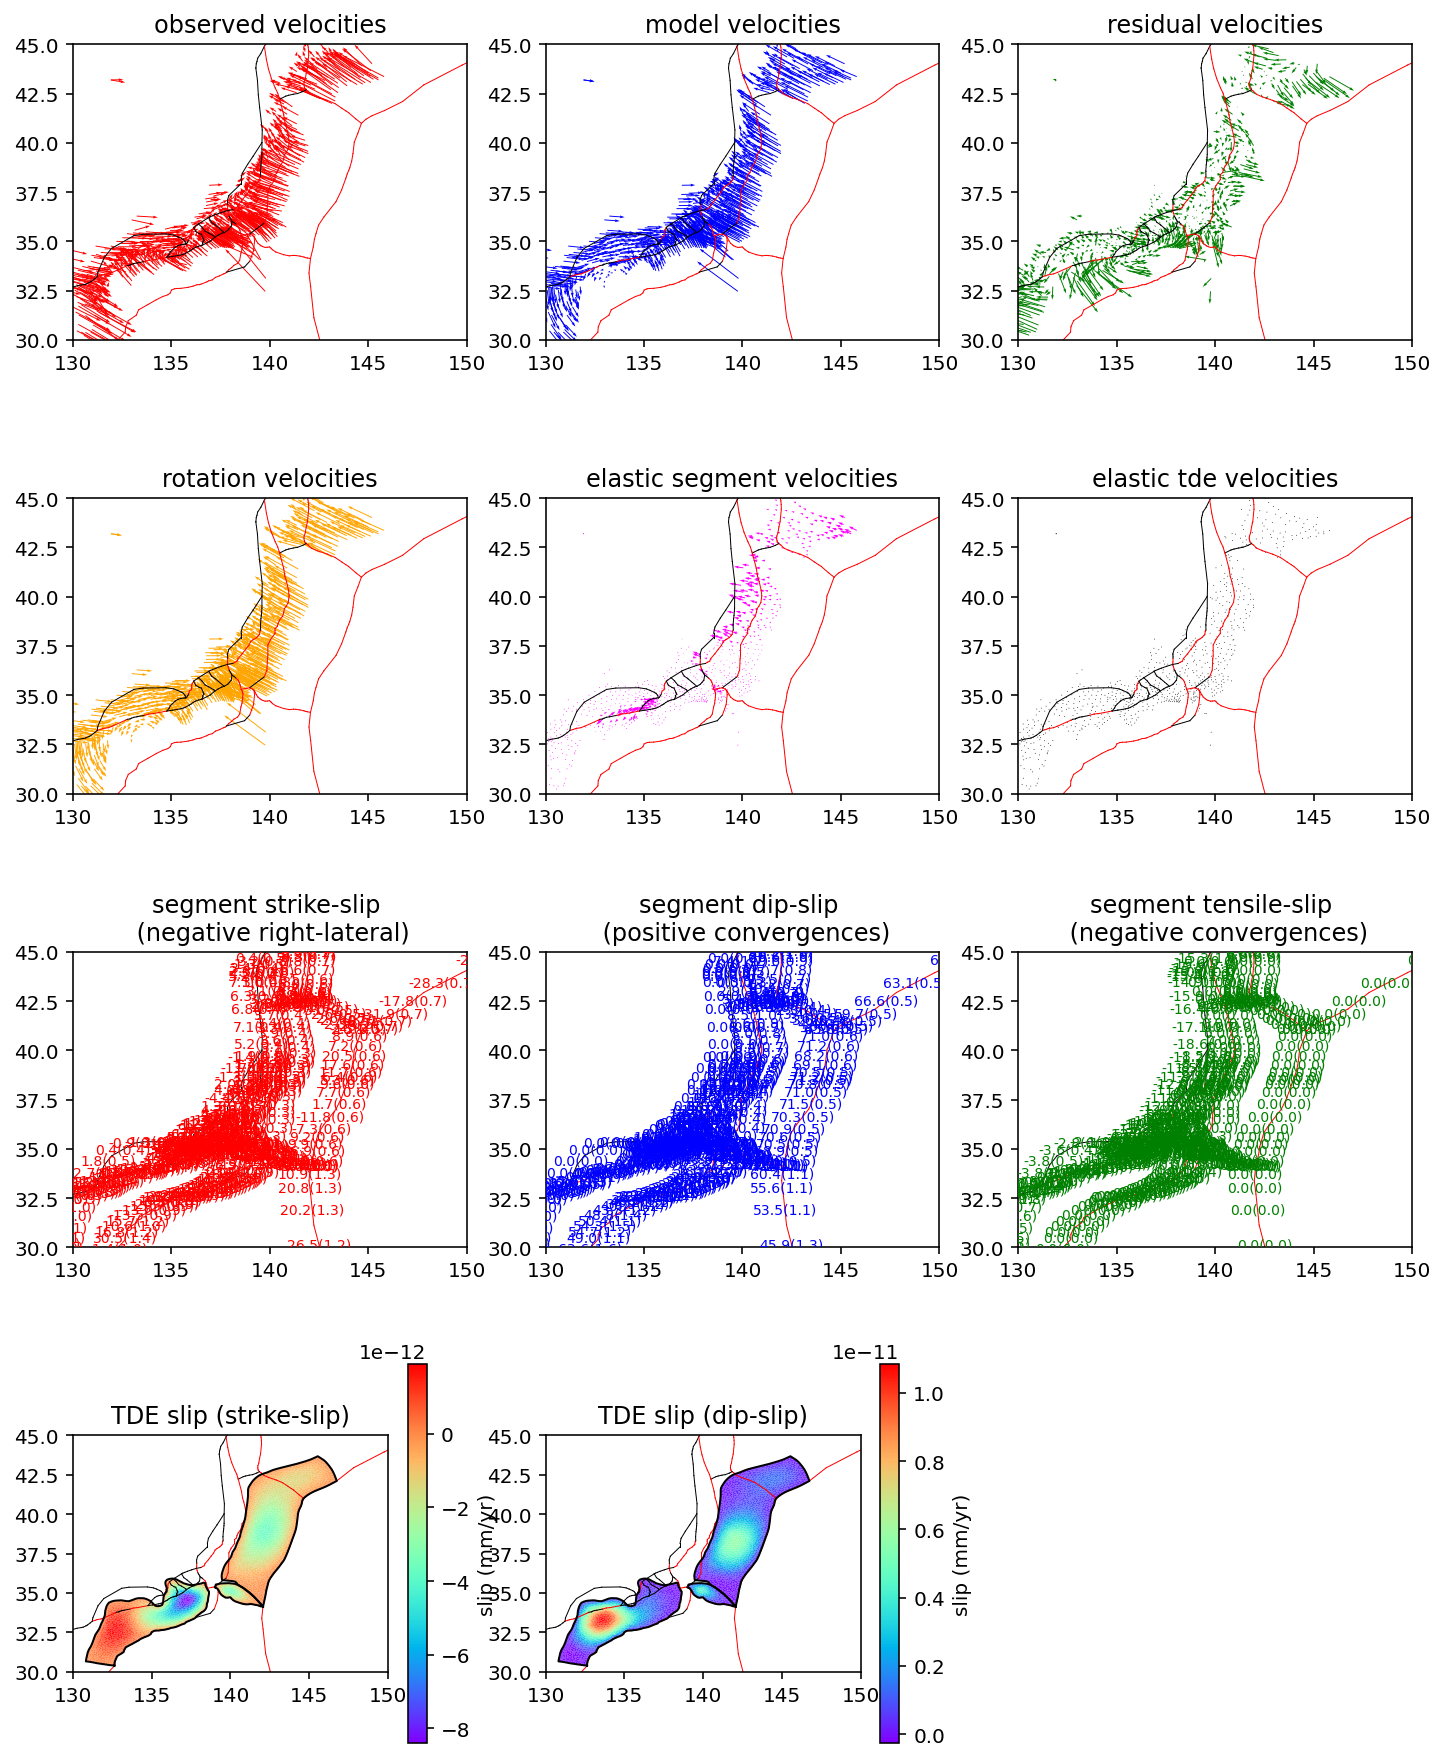

In [9]:
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Short matrix names and normalization for iterative solve experiments

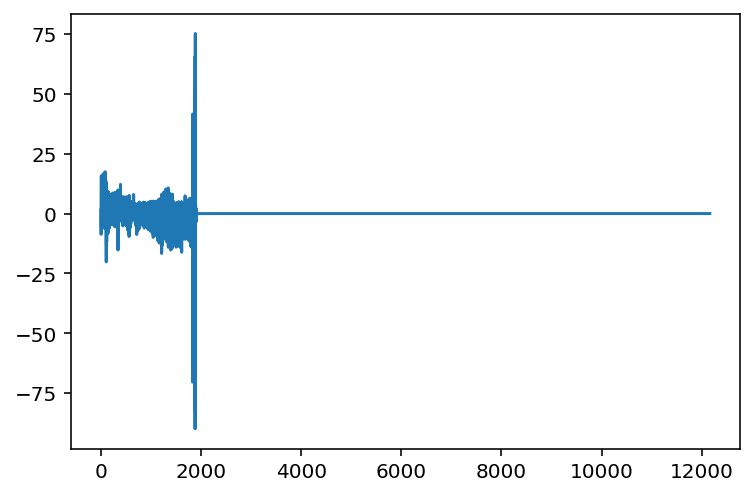

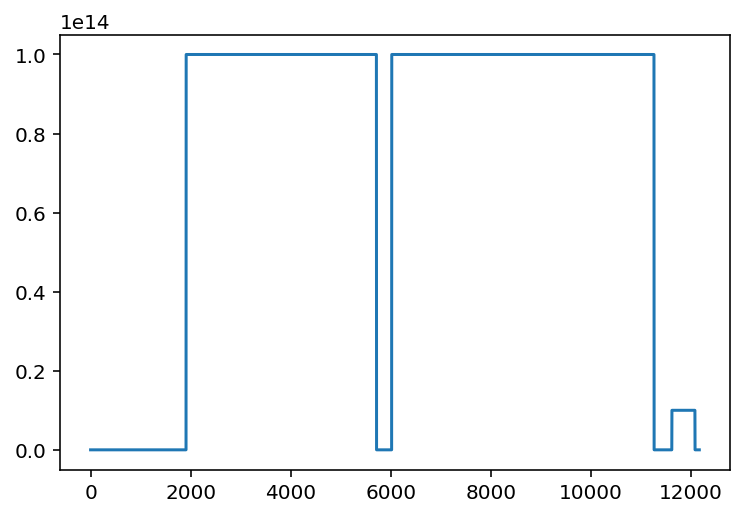

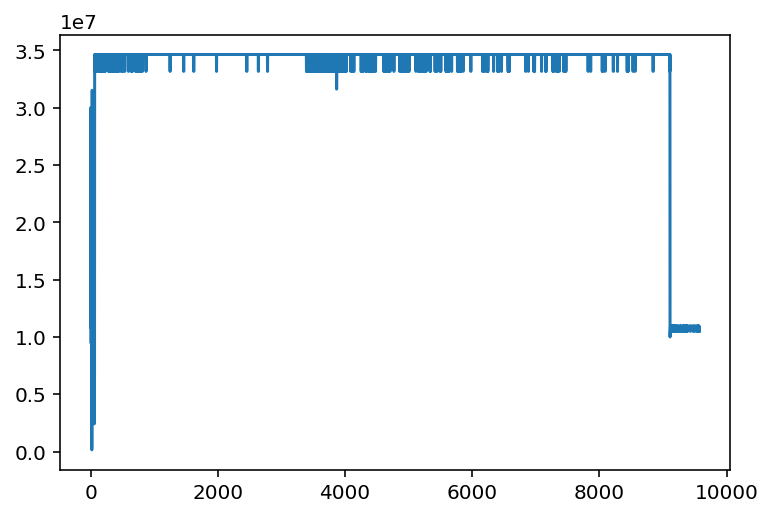

In [10]:
import scipy.sparse
import scipy.sparse.linalg

# Following TBT renaming
W = estimation.weighting_vector
X = estimation.operator
y = estimation.data_vector
Xp = X * np.sqrt(W)[:, None]
yp = y * np.sqrt(W)

# Normalize each column by column norms
col_norms = np.linalg.norm(Xp, axis=0)
XpP = Xp / col_norms[None, :]

# Tolerances for LSMR iterative solver
# As these get smaller the solutions do converge with the dense direct solution
atol = 1e-6
btol = 1e-6




plt.figure()
plt.plot(yp)
plt.show()
plt.figure()
plt.plot(W)
plt.show()
plt.figure()
plt.plot(col_norms)
plt.show()


np.save("col_norms_old.npy", col_norms)

# Dense iterative solve

In [11]:
# Size of dense matrix
print(XpP.nbytes)

# Iterative dense solution
%time lsmr_dense = scipy.sparse.linalg.lsmr(XpP, yp, atol=atol, btol=btol)

# Correct the solution for the col_norms preconditioning.
lsmr_dense_soln = lsmr_dense[0] / col_norms

931373152
CPU times: user 59.7 s, sys: 2.8 s, total: 1min 2s
Wall time: 8.23 s


# Sparse iterative solve

In [12]:
# Size of sparse matrix
print(scipy.sparse.csr_matrix(XpP).data.nbytes)

# Iterative sparse solution
%time lsmr_sparse = scipy.sparse.linalg.lsmr(scipy.sparse.csr_matrix(XpP), yp, atol=atol, btol=btol)

# Correct the solution for the col_norms preconditioning.
lsmr_sparse_soln = lsmr_sparse[0] / col_norms

146350800
CPU times: user 9.77 s, sys: 75 ms, total: 9.85 s
Wall time: 9.85 s


# Hmatrix iterative setup

In [13]:
# Cast all submatrices to sparse and put TDE to velocity matrices in a 3 element list
from scipy.sparse import csr_matrix
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

tde_matrices = []
sparse_tde_smoothing_matrices = []
sparse_tde_slip_rate_constraint_matrices = []
for i in range(len(meshes)):
    tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    smoothing_keep_index = celeri.get_keep_index_12(operators.smoothing_matrix[i].shape[0])
    tde_matrix = operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
    # tde_matrix = operators.tde_to_velocities[i]
    tde_matrices.append(tde_matrix)

    # TBTERROR: smoothing_matrix should be smoothing_matrix_simple
    sparse_tde_smoothing = csr_matrix(operators.smoothing_matrix[i][smoothing_keep_index, :][:, smoothing_keep_index])
    sparse_tde_smoothing_matrices.append(sparse_tde_smoothing)
    sparse_tde_slip_rate_constraints = csr_matrix(operators.tde_slip_rate_constraints[i])
    sparse_tde_slip_rate_constraint_matrices.append(sparse_tde_slip_rate_constraints)

In [14]:
from celeri.hmatrix import build_hmatrix_from_mesh_tdes
# from celeri.hmatrix import build_hmatrix_from_mesh_tdes_new # Only difference is that you can pass TDE matrix directly

H = []

for i in range(len(meshes)):
    H.append(build_hmatrix_from_mesh_tdes(
        meshes[i], 
        station,
        # TBTERROR: to match the code in estimation.operator construction, this
        # needs to be negative?
        -operators.tde_to_velocities[i],
        1e-6,
        # TBT: min_separation is a ratio of the sizes of the two tree nodes. The
        # exact criteria for two nodes being far enough apart that we are allowed to
        # use an approximate matrix block instead of an exact matrix block is:
        # dist > min_separation * (obs_node.radius + src_node.radius)
        min_separation=1.25,
        min_pts_per_box=20,
    ))

# H-matrix decomposition for each of the three meshes

In [15]:
def matvec(v):
    """ BJM: Build matvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns A* u

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: This will depend on how we integrate this into celeri and which
    variable we're talking about. For example, we should stop using X.shape
    entirely because that matrix won't exist in a fully sparse/hmatrix
    implementation!
    One design that I would probably lean towards
    would be something like:
    def build_sparse_hmatrix_linear_operator(operators,...):
        sparse_block_motion_okada_faults = ...
        define_other_precomputable_vars_here = ...

        def matvec(v):
            # use vars from the outer scope
        def rmatvec(v):
            # use vars from the outer scope

        return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)
        
    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    # TBT: It's important to remember to keep the input and output weighting
    # conceptually separate since the "out * np.sqrt(W)" will actually change
    # the solution to the least squares problem whereas the "v / col_norms"
    # preconditioning step is a reversible change to the solution (which is the
    # point since preconditioning should not change the solution!!)
    v_scaled = v / col_norms 

    # BJM: Make storage for output
    out = np.zeros(X.shape[0])
    block_rotations = v_scaled[index.start_block_col : index.end_block_col]

    # Okada
    out[index.start_station_row : index.end_station_row] += sparse_block_motion_okada_faults.dot(block_rotations)

    # Block motion constraints
    out[index.start_block_constraints_row : index.end_block_constraints_row] += sparse_block_motion_constraints.dot(block_rotations)

    # Slip rate constraints
    out[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] += sparse_block_slip_rate_constraints.dot(block_rotations)

    # Loop over TDE meshes
    # for i in range(len(meshes)):
    for i in range(3):
        tde_velocities = v_scaled[index.start_tde_col[i] : index.end_tde_col[i]]

        # Insert TDE to velocity matrix
        out[index.start_station_row : index.end_station_row] += H[i].dot(tde_velocities)

        # TDE smoothing
        out[index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]] += sparse_tde_smoothing_matrices[i].dot(tde_velocities)

        # TDE slip rate constraints
        out[index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]] += sparse_tde_slip_rate_constraint_matrices[i].dot(tde_velocities)

    # Weight!
    return out * np.sqrt(W)

In [16]:
sm0 = X[index.start_tde_smoothing_row[0]:index.end_tde_smoothing_row[0], :][:, index.start_tde_col[0]:index.end_tde_col[0]]
sm0

array([[ 3.,  0., -1., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ..., -1.,  0.,  3.]])

In [17]:
smoothing_keep_index = celeri.get_keep_index_12(operators.smoothing_matrix[0].shape[0])
operators.smoothing_matrix[0][smoothing_keep_index, :][:, smoothing_keep_index].toarray()

array([[ 3.,  0., -1., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ..., -1.,  0.,  3.]])

In [18]:
smoothing_keep_index = celeri.get_keep_index_12(operators.smoothing_matrix[0].shape[0])
operators.smoothing_matrix[0][smoothing_keep_index, :][:, smoothing_keep_index].toarray()

array([[ 3.,  0., -1., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ..., -1.,  0.,  3.]])

In [19]:
sparse_tde_smoothing_matrices[0].toarray()

array([[ 3.,  0., -1., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ..., -1.,  0.,  3.]])

In [20]:
index.start_block_col, index.end_block_col, index.start_tde_col, index.end_tde_col

(0, 63, {0: 63, 1: 3867, 2: 9109}, {0: 3867, 1: 9109, 2: 9571})

In [21]:
index.start_tde_smoothing_row, index.end_tde_smoothing_row, index.start_tde_constraint_row, index.end_tde_constraint_row

({0: 1908, 1: 6016, 2: 11614},
 {0: 5712, 1: 11258, 2: 12076},
 {0: 5712, 1: 11258, 2: 12076},
 {0: 6016, 1: 11614, 2: 12164})

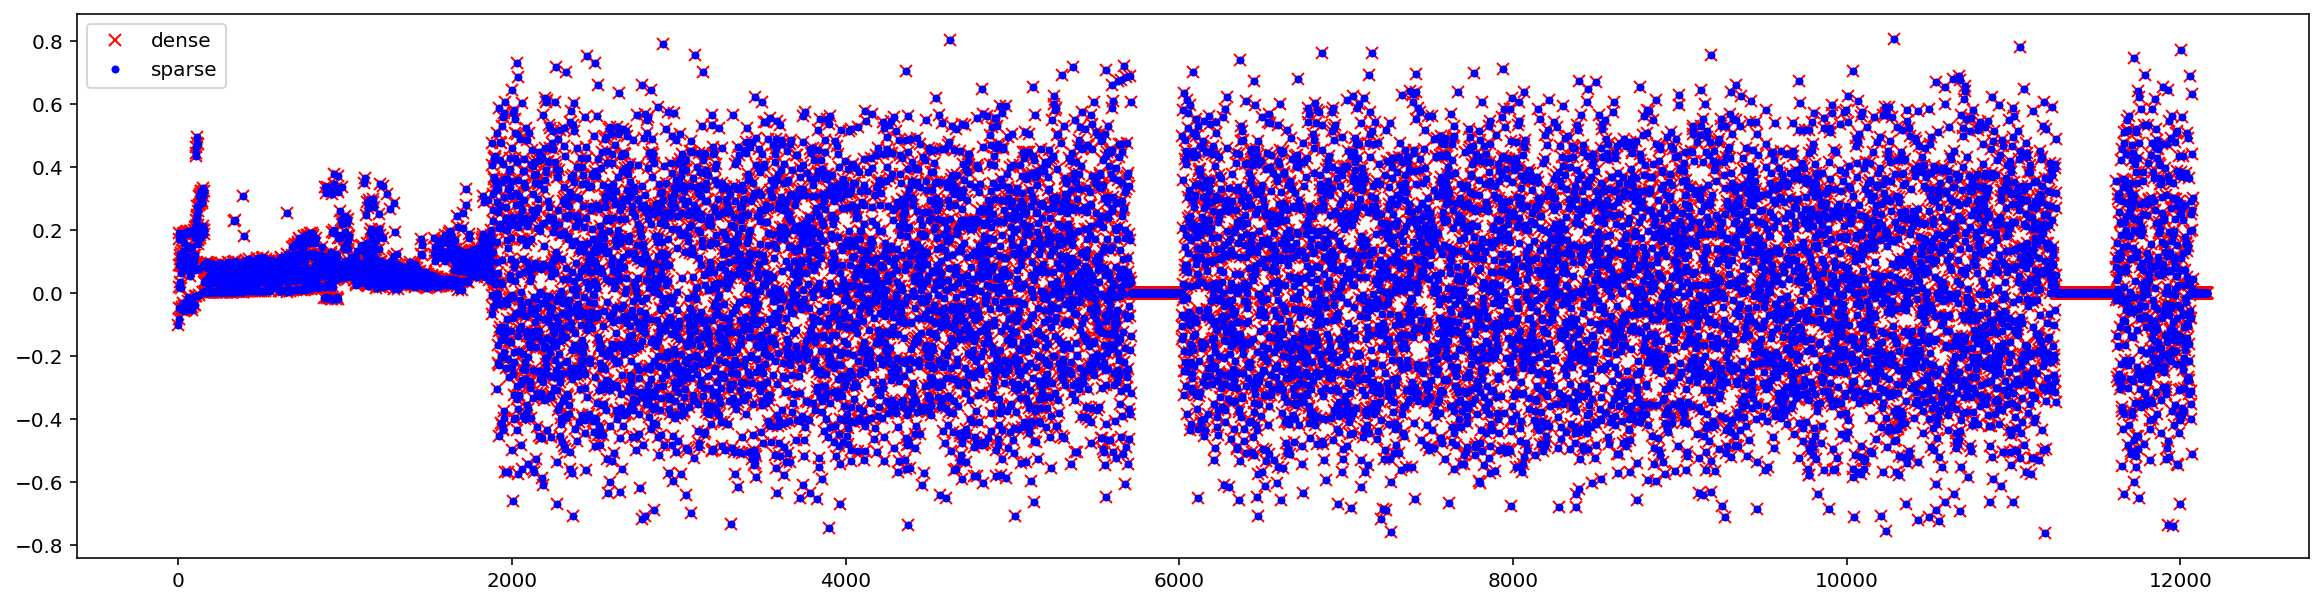

(12164, 9571)


In [22]:
# BJM: Compare dense matrix vector with matvec matrix vector product
rand_vec = np.random.rand(X.shape[1])
y1 = XpP.dot(rand_vec)
y2 = matvec(rand_vec)

plt.figure(figsize=(20, 5))
plt.plot(y1, 'rx', label='dense')
plt.plot(y2, 'b.', label='sparse')
# plt.xlim([1500,1550])
plt.legend()
plt.show()
print(XpP.shape)

In [23]:
def rmatvec(u):
    """ BJM: Build rmatvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns:
    Returns A^H * v, where A^H is the conjugate transpose of A
    for a candidate state vector, u.

    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    u_weighted = u * np.sqrt(W)

    # BJM: Storage for output
    out = np.zeros(X.shape[1])

    # BJM: Select subset of weighted data for the observed velocities
    station_rows = u_weighted[index.start_station_row : index.end_station_row]
    block_constraints = u_weighted[index.start_block_constraints_row : index.end_block_constraints_row]

    # BJM: Select subset of weighted data for the fault slip rate constraints
    slip_rate_constraints = u_weighted[index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row]

    # BJM: Okada and block rotation contribution to data vector
    out[index.start_block_col : index.end_block_col] += station_rows @ sparse_block_motion_okada_faults

    # BJM: Block motion constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += block_constraints @ sparse_block_motion_constraints

    # BJM: Fault slip rate constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += slip_rate_constraints @ sparse_block_slip_rate_constraints

    # TODO: Make this work over multiple meshes
    for i in range(len(meshes)):
        # BJM: Select subset of weighted data for the TDE smoothing
        tde_smoothing = u_weighted[index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]]

        # BJM: Select subset of weighted data for the TDE slip rate constraints
        tde_slip_rate = u_weighted[index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]]

        # BJM: Hmatrix (TDEs to velocities)
        out[index.start_tde_col[i] : index.end_tde_col[i]] += H[i].transpose_dot(station_rows)

        # BJM: TDE smoothing contribution to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += tde_smoothing @ sparse_tde_smoothing_matrices[i]

        # BJM: TDE slip rate constraint contributions to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += tde_slip_rate @ sparse_tde_slip_rate_constraint_matrices[i]

    # Weight!
    return out / col_norms

# Check the matrix vector multiply

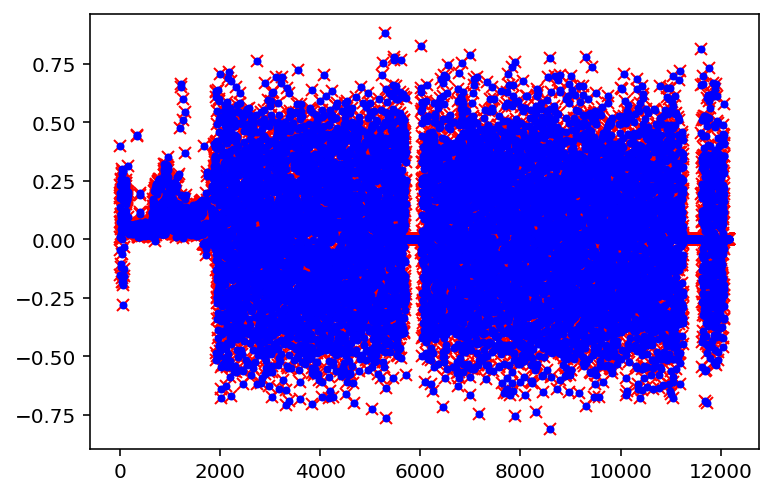

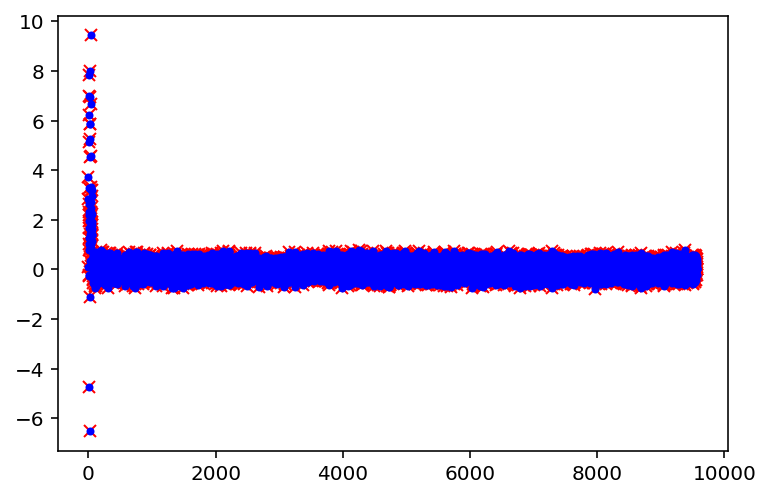

In [24]:
# BJM: Compare dense matrix vector with matvec matrix vector product
rand_vec = np.random.rand(X.shape[1])
y1 = XpP.dot(rand_vec)
y2 = matvec(rand_vec)
plt.plot(y1, 'rx', label='dense')
plt.plot(y2, 'b.', label='sparse')
plt.show()

# BJM: Testing that the rmatvec matrix vector product???
# TBT: Yes.
rand_vec = np.random.rand(X.shape[0])
y1 = rand_vec.dot(XpP)
y2 = rmatvec(rand_vec)
plt.plot(y1, 'rx', label='dense')
plt.plot(y2, 'b.', label='sparse')
plt.show()

In [25]:
# BJM: Create a linear operator the includes the hmatrix vector multiply
op = scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)

# BJM: How do "atol" and "btol" relate to "tol" that's passed to "build_hmatrix_from_mesh_tdes" above???
# TBT: They are unrelated. There are two approximations here:
# 1. The H-matrix approximation. This corresponds to the `tol` passed to `build_hmatrix_from_mesh_tdes`.
# 2. The iterative linear solver. The tolerances for this are here. I
# intentionally used very tight tolerances just to minimize the error coming
# from the lsmr solver. Below, I tried change the atol/btol to 1e-6 and the
# solution still looks good and runs about 3x faster than using 1e-13.
#
# You can see the exact meaning of atol and btol in the lsmr docs which I copied
# below: If Ax = b seems to be consistent, lsmr terminates when 
# norm(r) <= atol * norm(A) * norm(x) + btol * norm(b). 
# Otherwise, lsmr terminates when:
# norm(A^H r) <= atol * norm(A) * norm(r).
lsmr_sparse_hmatrix = scipy.sparse.linalg.lsmr(op, yp, atol=1e-6, btol=1e-6)

# Correct the solution for the col_norms preconditioning.
# lsmr_sparse_soln_hmatrix = lsmr_dense_hmatrix[0] / col_norms
lsmr_sparse_hmatrix_soln = lsmr_sparse_hmatrix[0] / col_norms

print('exit code: ', lsmr_sparse_hmatrix[1])
print('n_iterations: ', lsmr_sparse_hmatrix[2])
print('norm(b - Ax): ', lsmr_sparse_hmatrix[3])
print('norm(A^H (b - Ax)): ', lsmr_sparse_hmatrix[4])
print('norm(A): ', lsmr_sparse_hmatrix[5])
print('cond(A): ', lsmr_sparse_hmatrix[6])
print('norm(x): ', lsmr_sparse_hmatrix[7])

exit code:  2
n_iterations:  311
norm(b - Ax):  92.8625916026679
norm(A^H (b - Ax)):  0.001962650949580537
norm(A):  21.269831647358163
cond(A):  7.168242455916239
norm(x):  1717.2565927595429


# Compare solutions

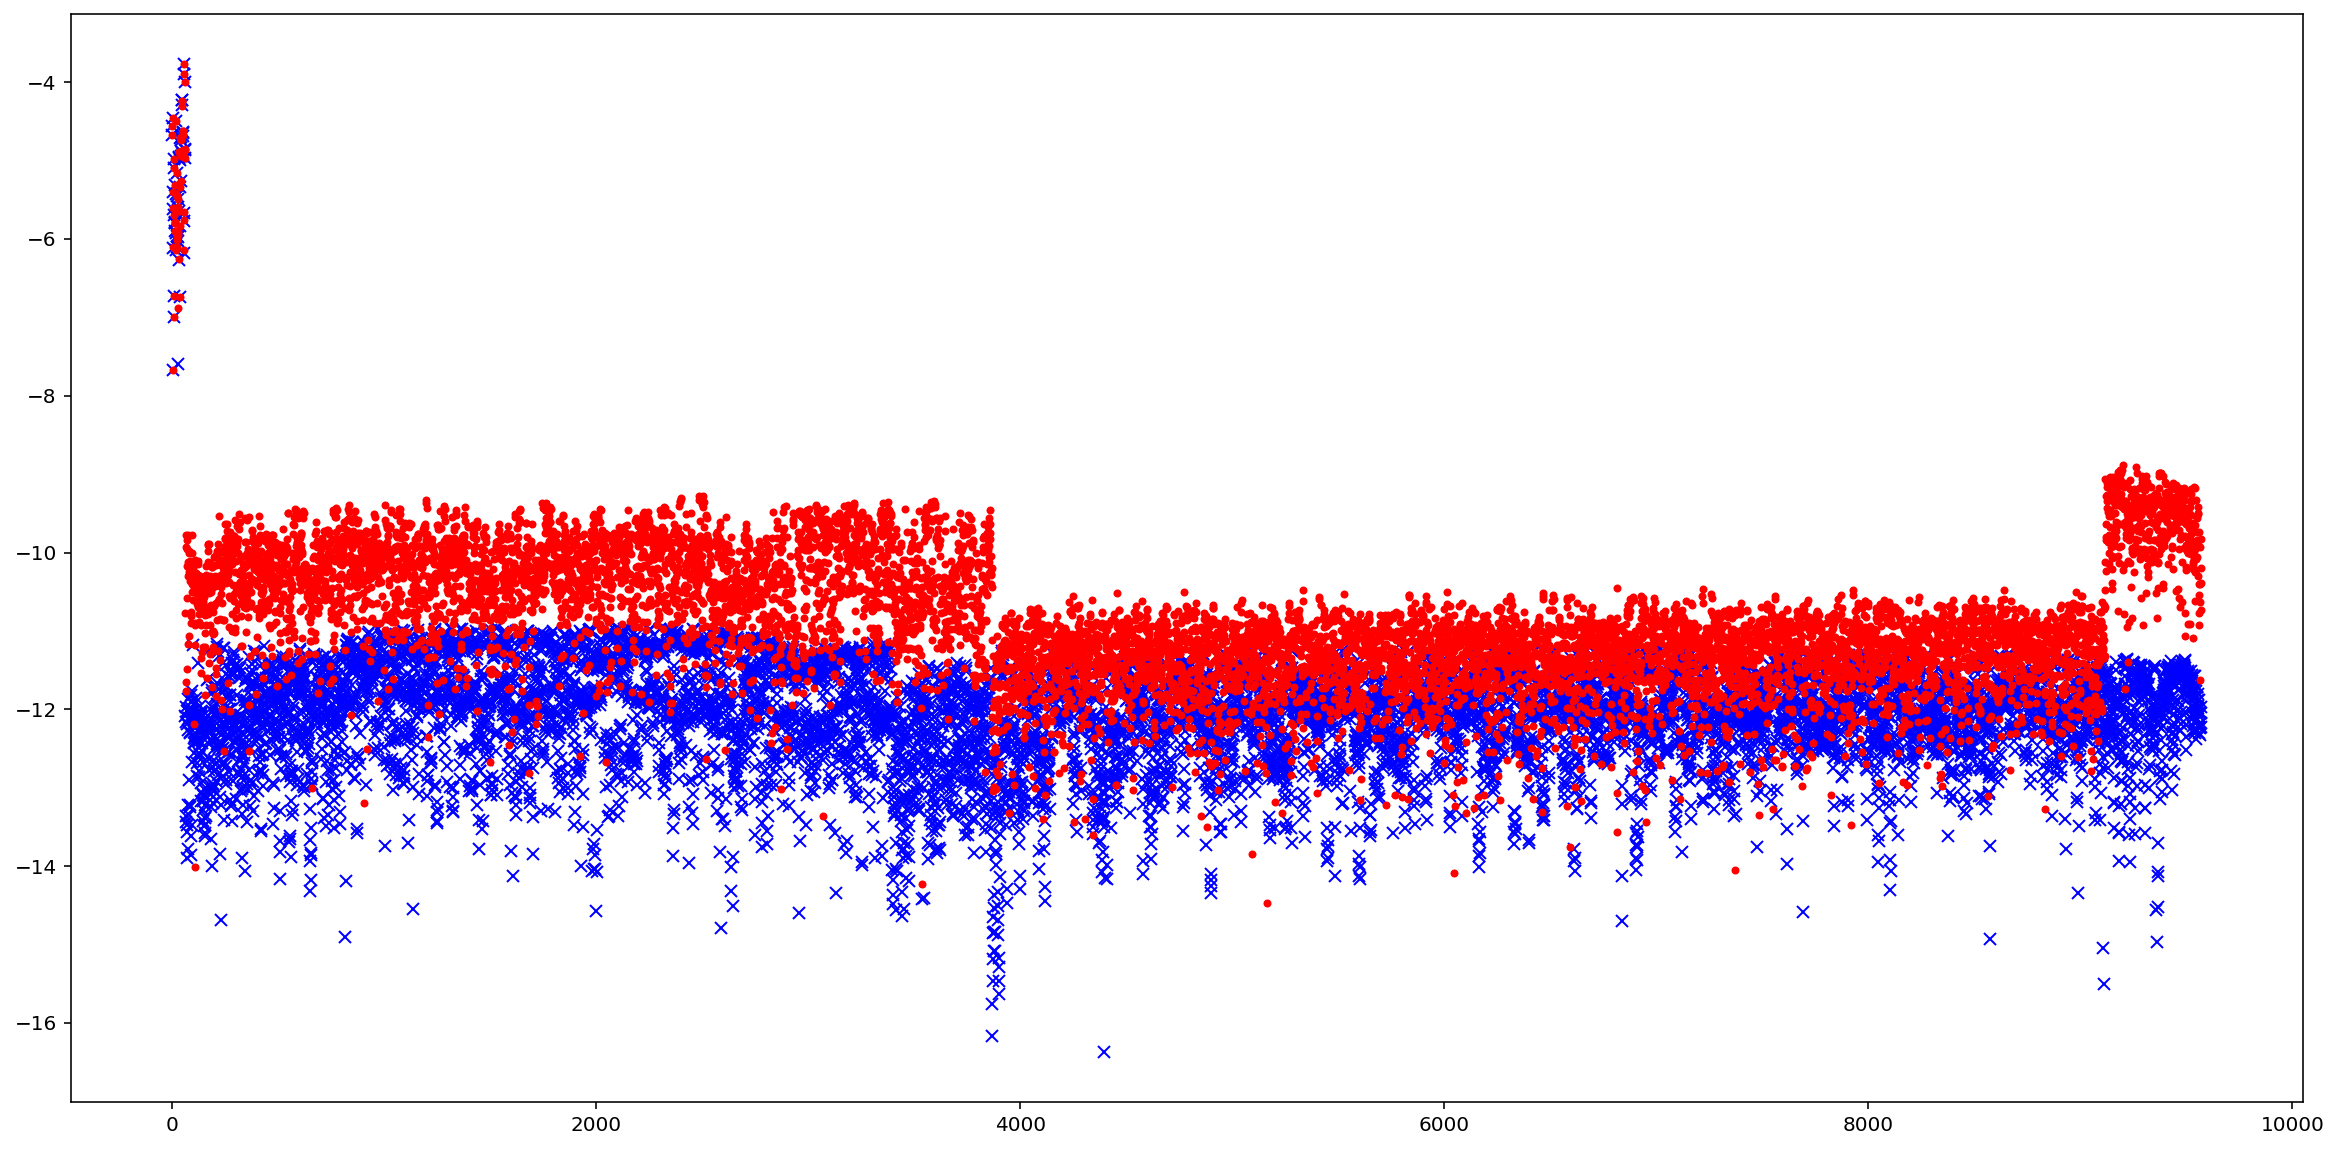

In [33]:
# plt.figure(figsize=(20, 10))
# plt.plot(estimation.state_vector, "gx")
# plt.plot(lsmr_dense_soln, "r+")
# plt.plot(lsmr_sparse_soln, "b.")
# plt.plot(lsmr_sparse_hmatrix_soln, "^c")

plt.figure(figsize=(20, 10))
plt.plot(np.log10(np.abs(estimation.state_vector)), "bx")
# plt.plot(np.log10(np.abs(lsmr_dense_soln)), "r+")
# plt.plot(np.log10(np.abs(lsmr_sparse_soln)), "b.")
plt.plot(np.log10(np.abs(lsmr_sparse_hmatrix_soln)), ".r")


In [27]:
a = Xp @ np.ones(Xp.shape[1])
b = op @ np.ones(Xp.shape[1])

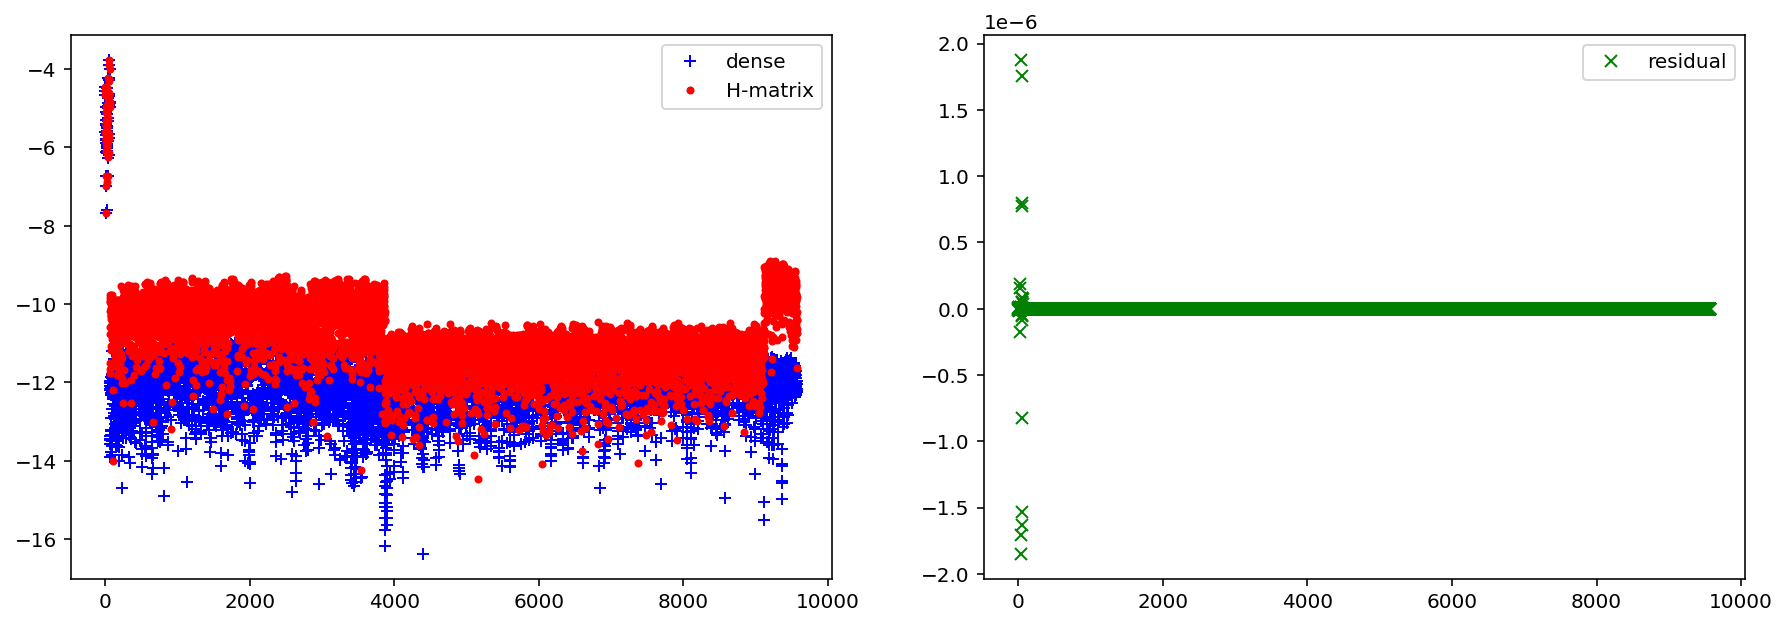

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.log10(np.abs(estimation.state_vector)), "+b", label="dense")
plt.plot(np.log10(np.abs(lsmr_sparse_hmatrix_soln)), "r.", label="H-matrix")
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(np.log10(np.abs(estimation.state_vector - sparse_hmatrix_state_vector)), "gx", label="residual")
plt.plot(estimation.state_vector - lsmr_sparse_hmatrix_soln, "gx", label="residual")
plt.legend()

plt.show()